*Running installs below:*

In [132]:
# !pip install sumy rake-nltk scikit-learn wordcloud matplotlib spacy nltk pytextrank
# !python -m spacy download fr_core_news_sm
# !python -m spacy download en_core_web_sm

In [133]:
# Import necessary libraries
#For spacy text ranking:
import spacy
# from spacy.language import Language
import pytextrank

#For sumy + rake text rankings:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('punkt_tab')
print(nltk.data.path)
nltk.download('stopwords') # Download stopwords resource
french_stopwords = stopwords.words('french')
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
from rake_nltk import Rake

#For TF-IDF + Ngram text rankings:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#For plotting
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# For file conversion: 
import json
import logging
from pathlib import Path
from spacy_layout import spaCyLayout

['/home/bglid/nltk_data', '/home/bglid/miniconda3/envs/br_int/nltk_data', '/home/bglid/miniconda3/envs/br_int/share/nltk_data', '/home/bglid/miniconda3/envs/br_int/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']


[nltk_data] Downloading package punkt to /home/bglid/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/bglid/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/bglid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### File Conversion using docling in Spacy:
 - It's set up to handle multiple file types currently.
 - Doing it through spacy is much more manageable and better for our use-case 

In [134]:
#Setting up paths from directory
# Testing our multiple paths at once with different file types
input_paths = [
    Path("../Radicalism_Verbalized_NLP/sample_data/casa tomada en Francais.docx"),
    Path("../Radicalism_Verbalized_NLP/sample_data/37-septembre-2008.pdf"),
    Path("../Radicalism_Verbalized_NLP/sample_data/fr_stopwords.txt")
]

In [135]:
# Setting up spacy file converter for french
nlp_converter = spacy.blank('fr')
layout = spaCyLayout(nlp_converter)

# processing a test document and creating a spacy object
test_pdf = Path("../Radicalism_Verbalized_NLP/sample_data/37-septembre-2008.pdf")
user_text = layout(test_pdf)

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [136]:
# Showing results of conversion:
# The text-based contents of the document
print(user_text.text)
# Document layout including pages and page sizes
print(user_text._.layout)
# Tables in the document and their extracted data
print(user_text._.tables)

Service de Veille scientifique et technologique

http://www.inrp.fr/vst

Dossier d'actualité (ancien titre : Lettre d'information) n° 37 -septembre 2008

vous abonner consulter le dossier en ligne

Genre et éducation

par Hélène Marguerite

Pendant de nombreuses années, la mise en avant des valeurs d'une école laïque, publique et républicaine a fait obstacle à une vraie reconnaissance des inégalités concrètes dans le système scolaire. La mixité qui s'est progressivement généralisée à partir de l'année 1960 n'a pas immédiatement signifié égalité. La recherche a beaucoup attendu avant de s'intéresser aux inégalités sexuées. Mais désormais, on essaie de comprendre comment et pourquoi les garçons et les filles sont traités différemment. Et de nombreuses recherches scientifiques font état de l'impact du genre en éducation et revisitent l'éducation sous l'angle du genre.

Concepts et définitions | Débats sur la mixité scolaire et paradoxes | Orientation et différenciation sexuée | Bibliograp

## The following cells are for NLP preprocessing of the data

In [137]:
# Adding a pipe that converters lemmas to lower
# using the decorator that allows custom components
# @Language.component("lowercasing")
# def lowercasing(doc) :
#     for token in doc :
#         token.lemma_ = token.lemma_.lower()
#     return doc

In [138]:
# Load SpaCy model
nlp = spacy.load('fr_core_news_sm')
nlp.add_pipe('textrank')
# nlp.add_pipe("lowercasing", after="lemmatizer")

In [139]:
# # Function to preprocess text
def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return tokens

In [170]:
# Function for TextRank keyword extraction using sumy
def extract_keywords_textrank(text):
    parser = PlaintextParser.from_string(text, Tokenizer('french'))
    summarizer = TextRankSummarizer()
    keywords = summarizer(parser.document, 10)  # Extract 10 keywords
    keywords = keywords
    return [str(kw).lower() for kw in keywords]

In [171]:
# Function for RAKE keyword extraction
def extract_keywords_rake(text):
    rake = Rake(stopwords=french_stopwords)
    rake.extract_keywords_from_text(text)
    return rake.get_ranked_phrases()

# Function for TF-IDF keyword extraction
def extract_keywords_tfidf(corpus):
    vectorizer = TfidfVectorizer(stop_words=french_stopwords, max_features=10)
    X = vectorizer.fit_transform(corpus)
    keywords = vectorizer.get_feature_names_out()
    return keywords

# Function for n-gram extraction
def extract_ngrams(text, n):
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words=french_stopwords)
    ngrams = vectorizer.fit_transform([text])
    return vectorizer.get_feature_names_out()

In [172]:
#Function for Spacy + Textrank keyword extraction:
def spacy_keywords(text):
    doc = nlp(text)
    #Getting the top phrases in the doc
    phrase_list = []
    for phrase in doc._.phrases:
        phrase_list.append(phrase.text)
        
    return phrase_list

In [173]:
# Function for keyword visualization
def visualize_keywords(keywords):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(keywords))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

## Below is the cell that allows the choice between manually entered text, or text entered via .txt upload

 - NOTE: Depending on Feedback, we'll want to adjust this to work best for team's use case.
 - Based on feedback, the cell below has been commented out, text will always be uploaded rather than added manually.

In [174]:
# # Asking the user to choose between entering text or uploading a file
# option = input("Would you like to upload a text file or enter text manually? Type 'file' for file upload or 'text' for manual entry: ")

# if option.lower() == 'text':
#     # Manually entering text
#     user_text = input("Please enter your sample text: ")

# elif option.lower() == 'file':
#     # Uploading a file
#     # uploaded = files.upload()
#     #Example of reading in a file from a directory
#     sample_dir = '../Radicalism_Verbalized_NLP/sample_data/fra_news_2023_100K-sentences.txt'

#     # Assuming a single file is uploaded and it's a .txt file
#     # file_name = next(iter(uploaded))  # Get the first uploaded file's name
#     with open(sample_dir, 'r') as file:
#         user_text = file.read()[:2500]
#     # user_text = docs

# else:
#     print("Invalid option. Please run the cell again and enter either 'file' or 'text'.")




TextRank Keywords: ["en 2008, de nombreuses enquêtes statistiques nationales et internationales décrivent la situation de la parité à l'école et comparent les parcours scolaires des filles et des garçons ainsi que leur socialisation différenciée ( filles et garçons à l'école, sur le chemin de l'égalité , 2008 ; ipsos, 2007 ).", "dans les années 2000, un certain nombre de recherches, d'abord anglo-saxonnes, ont commencé à mettre en doute les avantages de la mixité pour l'égalité des sexes quant aux performances respectives des garçons et des filles et quant aux relations entre les sexes.", 'des chercheurs dénoncent les effets néfastes de la mixité pour les filles et pour les garçons et remettent en question la mixité scolaire dans de nombreux pays occidentaux, notamment au québec (chaponnière, 2006 ).', "les chercheurs qui ont d'abord encouragé la mixité au nom de l'égalité entre les hommes et les femmes se sont aperçus que les objectifs escomptés n'étaient pas atteints même si la corr

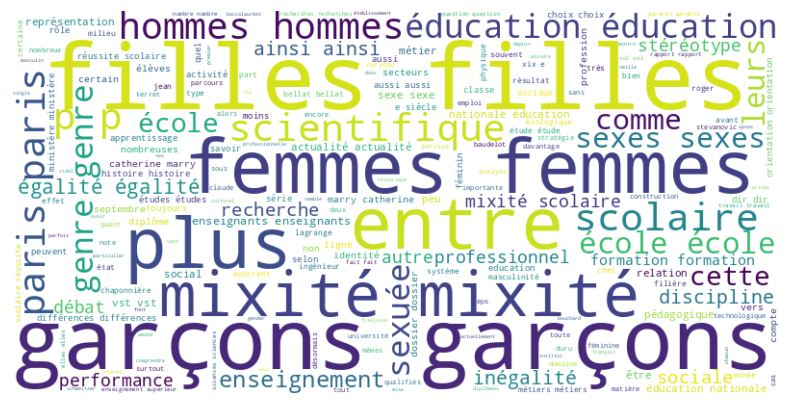

In [185]:
# Display the input text
# print("\nYour input text is:\n")
# print(user_text)

# # Preprocess the text
# processed_text = preprocess_text(user_text)
# print("\nPreprocessed Text:", processed_text)

# Keyword extraction using various methods
# TextRank using sumy
keywords_textrank = extract_keywords_textrank(user_text.text.lower())
print("\nTextRank Keywords:", keywords_textrank)

# RAKE
keywords_rake = extract_keywords_rake(user_text.text.lower())
print("\nRAKE Keywords:", keywords_rake)

#Spacy Example:
keywords_spacy = spacy_keywords(user_text.text.lower())
print(f'\nSpacy Keywords: {keywords_spacy}')

# TF-IDF (providing corpus as a list with one entry)
corpus = [user_text.text]
keywords_tfidf = extract_keywords_tfidf(corpus)
print("\nTF-IDF Keywords:", keywords_tfidf)

# n-grams (bigram example)
ngrams = extract_ngrams(user_text.text, 2)
print("\nBigrams:", ngrams)

# Visualization of keywords
visualize_keywords(keywords_rake)